In [1]:
import pandas as pd
import numpy as np
import io
import os
import re
import sys
from pandasql import sqldf
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import jieba
import json
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data\\weibo_spider_data'
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
stop_words_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP\\recomend_system\\Chinese\\hit_stopwords.txt'

sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf
import nlpbasic.dataExploration as dataExploration

import plotly.express as px

C:\Users\luoyan011\.conda\envs\nlp\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
weibo_data = pd.read_csv(os.path.join(root_path, "龚俊.csv"))
weibo_data['发布时间'] = pd.to_datetime(weibo_data['发布时间'])
weibo_data.head(3)

,id,bid,user_id,用户昵称,微博正文,头条文章url,发布位置,艾特用户,话题,转发数,评论数,点赞数,发布时间,发布工具,微博图片url,微博视频url,retweet_id
0,4698164609156170,KFbI0CpWa,1799411494,慕栀颜,龚俊gj#龚俊代言梦幻西游#简单调色89截修又是被俊俊子迷倒的一个周末@龚俊Simon,NaN,NaN,龚俊Simon,龚俊代言梦幻西游,0,0,0,2021-10-31 00:59:00,微博国际版,['http://tps:/large/wx3.sinaimg.cn/thumb150/6b...,NaN,NaN
1,4698164596575102,KFbHZrAu2,2292685847,·咖啡一杯半·,晚安我滴宝明天也不上班咩宝咪睡个懒觉捏@龚俊Simon,NaN,NaN,龚俊Simon,NaN,0,0,0,2021-10-31 00:59:00,俊子歌迷的iPhone 12 Pro Max,['http://tps:/large/wx1.sinaimg.cn/orj360/88a7...,NaN,NaN
2,4698164566688857,KFbHWs44N,1767095754,颖想祺裕,而你刚好发光这周@网剧而你刚好发光看到18集，#龚俊方岩#总的出场时间并不算长，但是有好多让...,NaN,NaN,"网剧而你刚好发光,龚俊Simon",龚俊方岩,0,6,0,2021-10-31 00:59:00,而你刚好发光超话,['http://tps:/large/wx4.sinaimg.cn/thumb150/69...,NaN,NaN


In [17]:
print('start read stopwords data.')
stopwords = []
with open(stop_words_path, 'r', encoding='utf-8') as f:
    for line in f:
        if len(line)>0:
            stopwords.append(line.strip())
stopwords = stopwords+['Simon','龚俊']
print(stopwords)
def preprocess_text(text):
    try:
        segs=jieba.lcut(text)
        segs = filter(lambda x:len(x)>1, segs)
        segs = [v for v in segs if not str(v).isdigit()]#去数字
        segs = list(filter(lambda x:x.strip(), segs)) #去左右空格
        segs = filter(lambda x:x not in stopwords, segs)
        temp = " ".join(segs)
        return(temp)
    except Exception:
        pass
weibo_data['tokenizer'] = weibo_data['微博正文'].apply(lambda x: preprocess_text(x))


start read stopwords data.
['———', '》），', '）÷（１－', '”，', '）、', '＝（', ':', '→', '℃', '&', '*', '一一', '~~~~', '’', '.', '『', '.一', './', '--', '』', '＝″', '【', '［＊］', '｝＞', '［⑤］］', '［①Ｄ］', 'ｃ］', 'ｎｇ昉', '＊', '//', '［', '］', '［②ｅ］', '［②ｇ］', '＝｛', '}', '，也', '‘', 'Ａ', '［①⑥］', '［②Ｂ］', '［①ａ］', '［④ａ］', '［①③］', '［③ｈ］', '③］', '１．', '－－', '［②ｂ］', '’‘', '×××', '［①⑧］', '０：２', '＝［', '［⑤ｂ］', '［②ｃ］', '［④ｂ］', '［②③］', '［③ａ］', '［④ｃ］', '［①⑤］', '［①⑦］', '［①ｇ］', '∈［', '［①⑨］', '［①④］', '［①ｃ］', '［②ｆ］', '［②⑧］', '［②①］', '［①Ｃ］', '［③ｃ］', '［③ｇ］', '［②⑤］', '［②②］', '一.', '［①ｈ］', '.数', '［］', '［①Ｂ］', '数/', '［①ｉ］', '［③ｅ］', '［①①］', '［④ｄ］', '［④ｅ］', '［③ｂ］', '［⑤ａ］', '［①Ａ］', '［②⑧］', '［②⑦］', '［①ｄ］', '［②ｊ］', '〕〔', '］［', '://', '′∈', '［②④', '［⑤ｅ］', '１２％', 'ｂ］', '...', '...................', '…………………………………………………③', 'ＺＸＦＩＴＬ', '［③Ｆ］', '」', '［①ｏ］', '］∧′＝［', '∪φ∈', '′｜', '｛－', '②ｃ', '｝', '［③①］', 'Ｒ．Ｌ．', '［①Ｅ］', 'Ψ', '－［＊］－', '↑', '.日', '［②ｄ］', '［②', '［②⑦］', '［②②］', '［③ｅ］', '［①ｉ］', '［①Ｂ］', '［①ｈ］', '［①ｄ］', '［①ｇ］', '［①②］', '［②ａ］', 'ｆ］', '

In [18]:
import pprint 
text = weibo_data['tokenizer']
sentences = [] 
for item in text:     
    sentence = str(item).split(' ')     
    sentences.append(sentence)


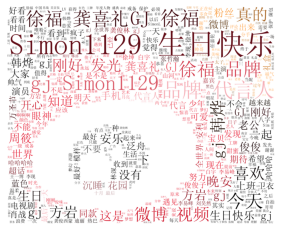

In [19]:
# get word cloud plot
from numpy import array, concatenate, atleast_1d
pandemic_weibo = list(weibo_data['tokenizer'])
all_tokens = concatenate([atleast_1d(a) for a in pandemic_weibo])
all_tokens = " ".join(all_tokens)
img_link = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data\\chinese_recommender\\weibo.png'
font_path = "C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP\\recomend_system\\Chinese\\simsun.ttf"
DataExploration.generate_chinese_word_cloud(all_tokens, img_link, font_path ,stopwords = '', color_control = True, save = True)
